In [1]:
import numpy as np
import seaborn as sns
import scipy
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from matplotlib import cm, colormaps, colors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from scipy.spatial import ConvexHull
from scipy.spatial import distance
import itertools
from voronoi_utils import *


In [2]:
xMin= 0
xMax=1000
yMin=0
yMax=1000

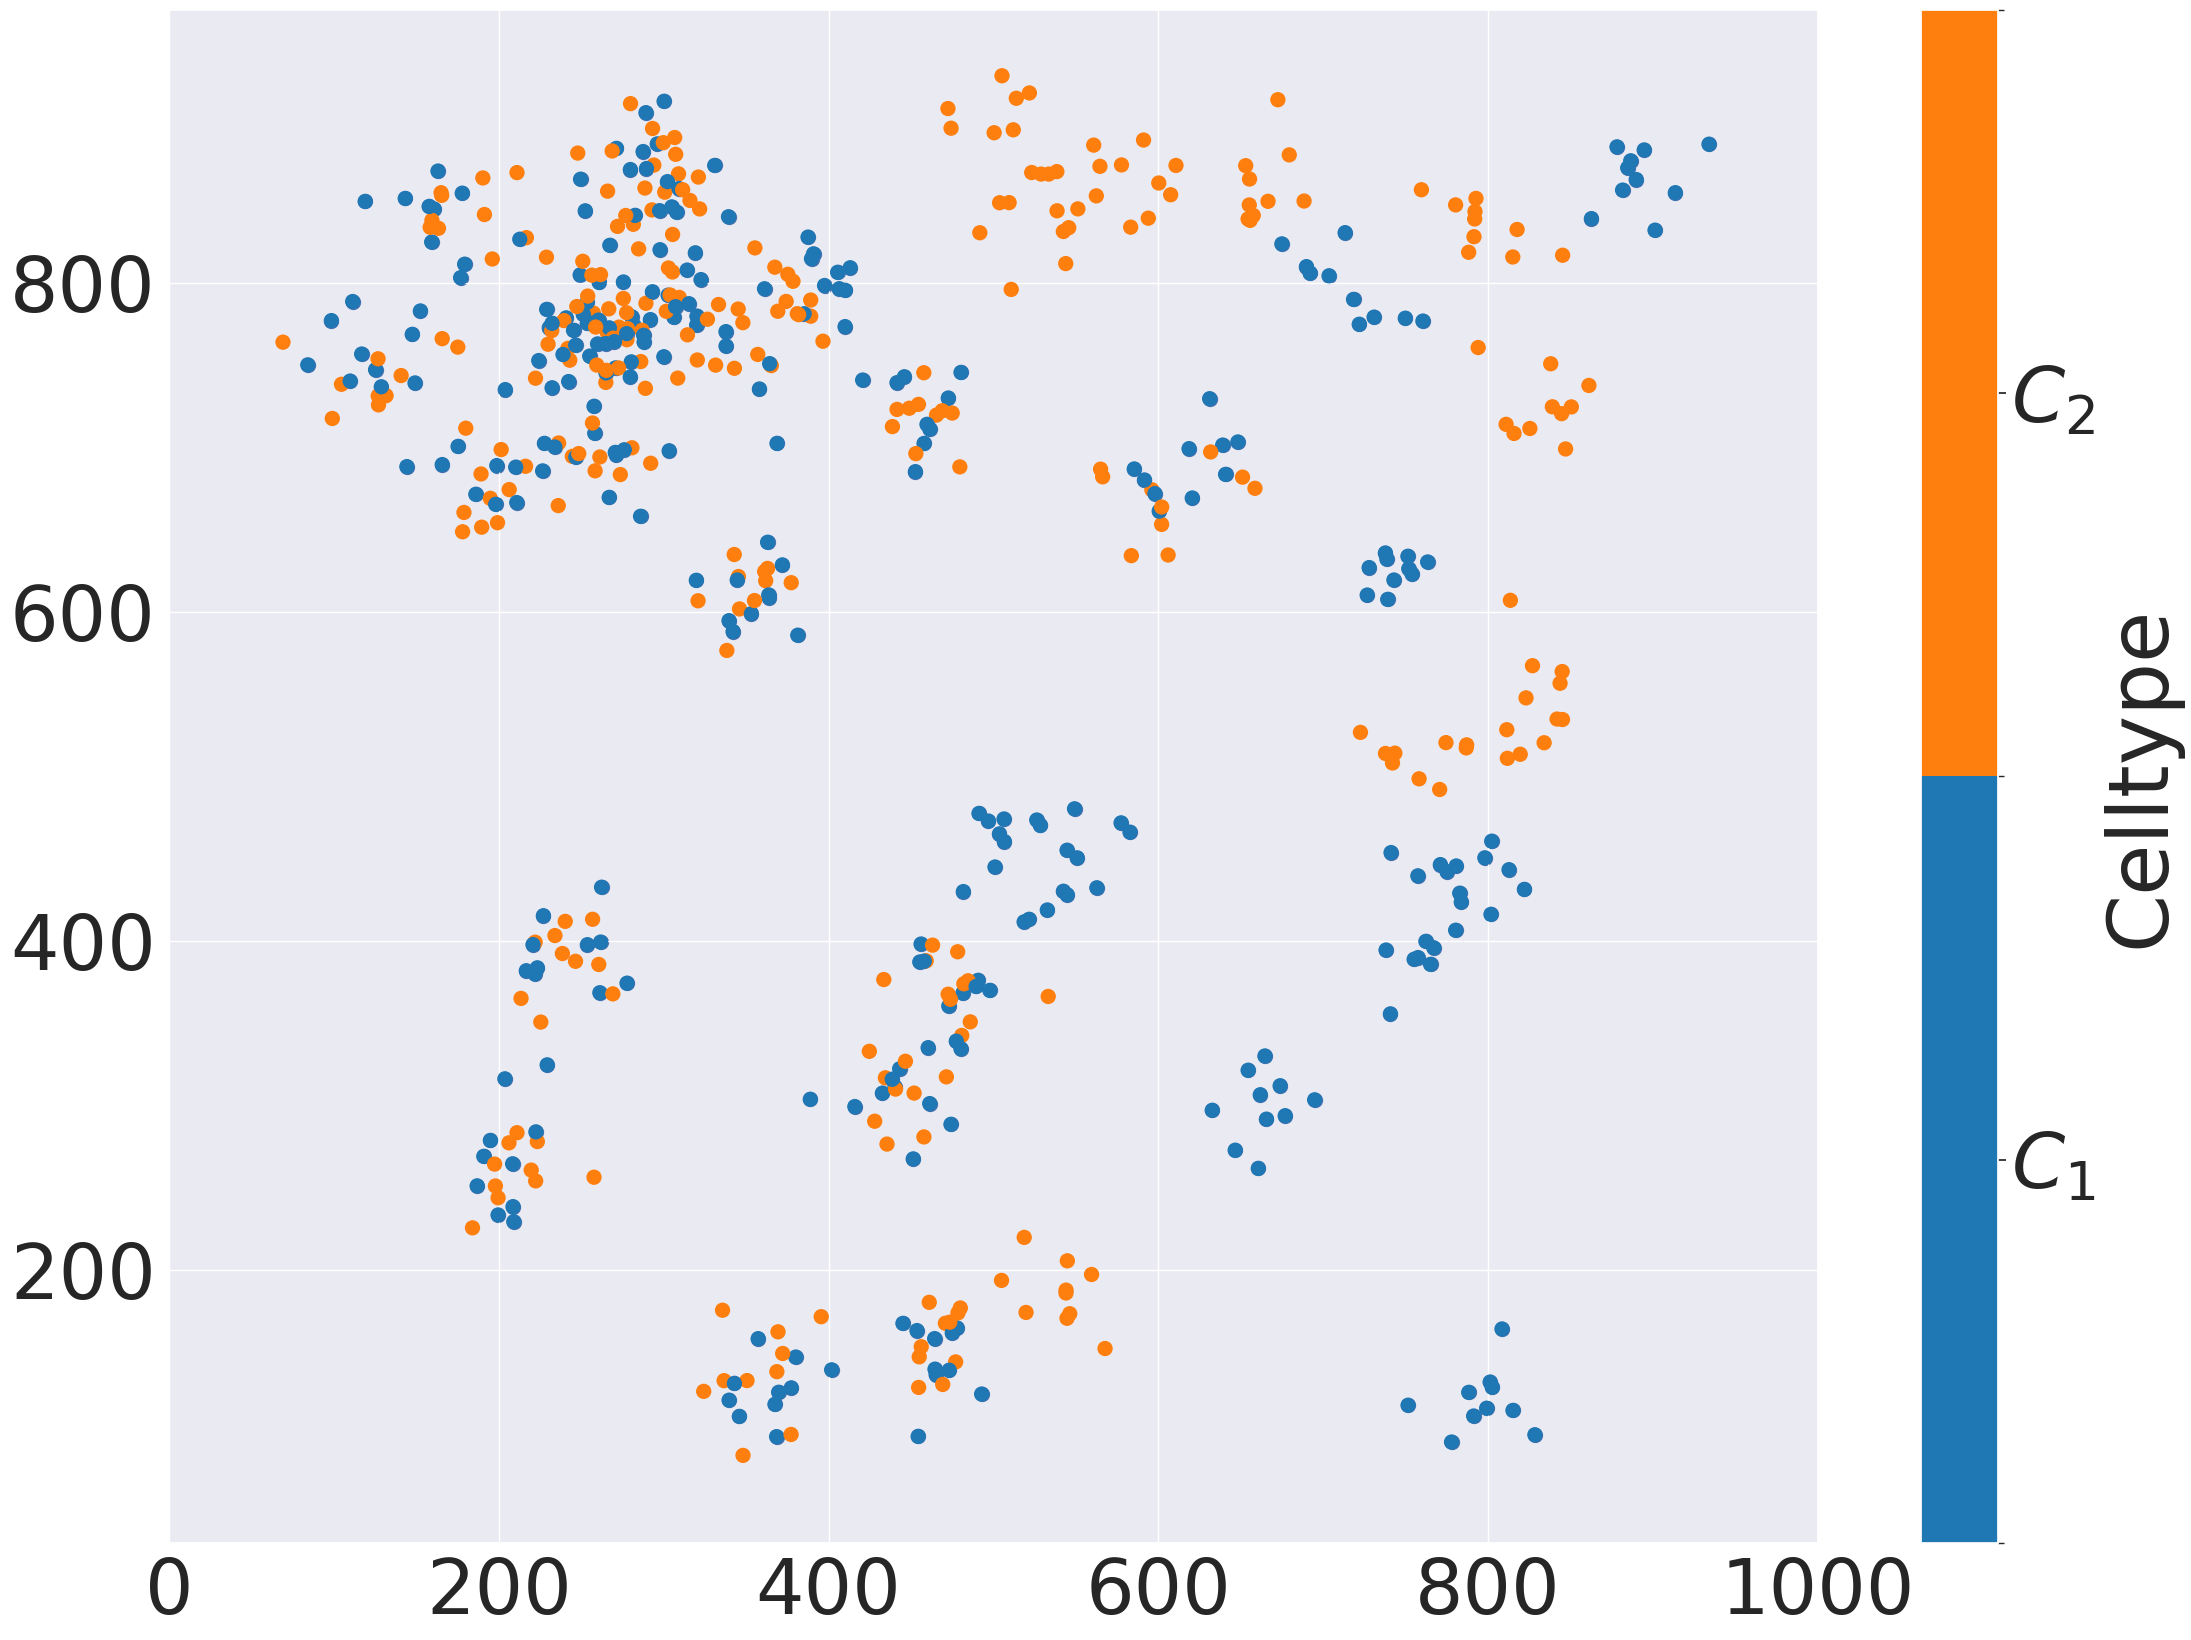

In [3]:
from SyntheticDataset1_functions import generate_synthetic_dataset1, cross_pcf_synthetic_dataset1
pc, c1mask = generate_synthetic_dataset1()
plt.savefig("figures/synthetic_d1.png")

points1 = pc.points

In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

# plt.rcParams.update({'font.size': 10})


In [ ]:
# ----- 1 class -----
# for each pixel p
# draw a circle C of radius r around p
# build a voronoi set of cells with points inside C
# sample points p_i on C
# for each p_i, calculate its voronoi distance to p
# average over p_i
# normalize by expected voronoi distance to points on circle for ideal gas

In [5]:
def sample_on_circle(p, r, N_circle):

    angles = np.pi * np.random.uniform(0, 2, N_circle)
    xs = r * np.cos(angles)
    ys = r * np.sin(angles)

    p_is = np.concatenate(([xs], [ys]), axis = 0).transpose() + p

    return p_is

    # plt.scatter(p_is[:,0], p_is[:,1])

In [6]:
# find points in circle of each class

def find_data_points_in_disk(points, p, r, c1mask, c2mask = None):
    
    if c2mask is None:
        c2mask = np.logical_not(c1mask)
        
    filter_in_circle = np.squeeze(distance.cdist(points, p) < r)
    
#     print(points.shape)
#     print(p)
    
    
    filter_c1_circle = np.multiply(filter_in_circle, c1mask)
    filter_c2_circle = np.multiply(filter_in_circle, c2mask)

    points_circle_c1 = points[filter_c1_circle]
    points_circle_c2 = points[filter_c2_circle]
    
    return points_circle_c1, points_circle_c2

# plt.scatter(s1[:,0], s1[:,1])
# plt.scatter(p[:,0], p[:,1], c='k', marker = 'x')
# plt.scatter(s2[:,0], s2[:,1])

# plt.scatter(p_is[:,0], p_is[:,1])

In [7]:
def get_distances_on_circle(p, cur_points, p_is) :
    # for one class
    ds_circle = np.zeros(len(p_is))
    
    vor = Voronoi_cells(cur_points, show=False)
    adj = make_adj_matrix(vor)
    shortest_path_dists = compute_shortest_path_dist(adj)
    #     visualize_voronoi_source(shortest_path_dists, vor, source = 0)

    index_closest_point_p = np.argmin(distance.cdist(cur_points, p)) # find index of the point p is closest to
    cell_p = vor.point_region[index_closest_point_p] # find the index of the associated voronoi cell

    for i, p_i in enumerate(p_is):
        p_i = np.expand_dims(p_i, axis=0)
        index_closest_point_pi = np.argmin(distance.cdist(cur_points, p_i)) # find index of the point p_i is closest to
        cell_pi = vor.point_region[index_closest_point_pi]
        d = shortest_path_dists[cell_pi, cell_p]
        ds_circle[i] = d
        
    return ds_circle


def avg_on_circle_distance_of_distances(points, p, r, c1mask, c2mask=None, N_circle = 100, dissimilarity = 'squared_distance', normalization_factor= 1):
        
    # for one pixel, for the two classes
    
    p = np.expand_dims(np.asarray(p), axis=0)
    ds_classes=[]

    # find points in circle of each class
    points_circle_c1, points_circle_c2 = find_data_points_in_disk(points, p, r, c1mask, c2mask)
    p_is = sample_on_circle(p, r, N_circle) # so that the points are the same for both classes

    # if number of points for both classes is too low, we can't compute voronoi cells so we don't know if they are colocalized. we set them to NA
    if len(points_circle_c1) < 4 and len(points_circle_c2) < 4 :
        ds_classes = [np.nan, np.nan]    

    else:
        for cur_points in [points_circle_c1, points_circle_c2]: # for each class
            if len(cur_points) > 3: # Voronoi needs at least 4 points to make the cells
                ds_circle = get_distances_on_circle(p, cur_points, p_is)
                ds = ds_circle
            else:
                #ds = ds + [np.nan for p_i in p_is]
                ds = np.zeros(len(p_is))

            ds_classes.append(ds)

    if dissimilarity == "difference":
        dissimilarity_between_distances = np.array(ds_classes[0], dtype= 'float') - np.array(ds_classes[1], dtype= 'float')

    elif dissimilarity == "squared_distance":
        dissimilarity_between_distances = np.square(np.array(ds_classes[0], dtype= 'float') -  np.array(ds_classes[1], dtype= 'float') )
    
    elif dissimilarity == "squared_distance_normalized":
        dissimilarity_between_distances = np.square(np.array(ds_classes[0]/normalization_factor, dtype= 'float') -  np.array(ds_classes[1]/normalization_factor, dtype= 'float') )
    
    
    else:
        print("dissimilarity not supported")

    avg_on_circle = np.mean(dissimilarity_between_distances)
    
    return avg_on_circle



def compute_avg_dissimilarity_classes_pixels(points, pixels, r, c1mask, c2mask=None, N_circle = 100, dissimilarity = "squared_distance", normalization_factor=1):  
    
    d_pixels = np.zeros((pixels.shape[0], 1))

    for i, p in enumerate(pixels):
        avg_on_circle = avg_on_circle_distance_of_distances(points, p, r, c1mask, c2mask, N_circle, dissimilarity, normalization_factor)
        d_pixels[i] = avg_on_circle
        
    return d_pixels



In [8]:
def get_var_on_circle(points, p, r, N_circle = 100, dissimilarity = 'squared_distance', normalization_factor= 1):
        
    # for one pixel
    
    p = np.expand_dims(np.asarray(p), axis=0)
    ds_classes=[]

    # find points in circle
    points_circle, points_circle_c2 = find_data_points_in_disk(points, p, r, c1mask = np.ones(len(points)).astype(bool)) # pretend all points are c1
    p_is = sample_on_circle(p, r, N_circle) 
    
#     print(points_circle)
    
    # if number of points for both classes is too low, we can't compute voronoi cells
    if len(points_circle) < 4:
        ds_circle = np.nan    

    else:
        ds_circle = get_distances_on_circle(p, points_circle, p_is)
        
    var_on_circle = np.var(ds_circle)
    
    return var_on_circle


def compute_var_pixels(points, pixels, r, N_circle = 100):
    
    var_pixels = np.zeros((pixels.shape[0], 1))

    for i, p in enumerate(pixels):
        var_on_circle = get_var_on_circle(points, p, r, N_circle)
        var_pixels[i] = var_on_circle
        
    return var_pixels

In [18]:
# def compute_avg_dist_pixels_class(points, pixels, r, c1mask, c2mask=None, N_circle = 100):
    
#     avg_d_pixels = np.zeros((pixels.shape[0], 2))

#     for i, p in enumerate(pixels):

#         p = np.expand_dims(np.asarray(p), axis=0)
        
#         avg_ds_classes=[]

#         # find points in circle of each class
#         points_circle_c1, points_circle_c2 = find_data_points_in_disk(points, p, r, c1mask, c2mask)
#         p_is = sample_on_circle(p, r, N_circle) # so that the points are the same for both classes
 
#         # if number of points for both classes is too low, we can't compute voronoi cells so we don't know if they are colocalized. we set them to NA
#         if len(points_circle_c1) < 4 and len(points_circle_c2) < 4 :
#             avg_ds_classes = [np.nan, np.nan]    
        
#         else:
#             for cur_points in [points_circle_c1, points_circle_c2]: # for each class
#                 if len(cur_points) > 3: # Voronoi needs at least 4 points to make the cells
#                     ds_circle = get_distances_on_circle(p, cur_points, p_is)
#                     ds = ds_circle
#                 else:
#                     #ds = ds + [np.nan for p_i in p_is]
#                     ds = np.zeros(len(p_is))                
                
#                 avg_d = np.mean(ds) # for each class
# #                 print(avg_d)
#                 avg_ds_classes.append(avg_d)
                
# #         print(avg_ds_classes)
       
#         avg_d_pixels[i, :] = avg_ds_classes
        
#     return avg_d_pixels

In [13]:
# different plotting function
def get_custom_cmap_classes(diffs, rgb_c1= (0, 0.4, 0.7), rgb_c2 = (1.0, 0.45, 0.0), cmap_norm = "linear"):
    
    set_of_colors_c1 = [(1, 1, 1), rgb_c1] # first color is white, last is blue
    set_of_colors_c2 = [rgb_c2, (1, 1, 1),] # first color is orange, last is white
    colors_c1 = LinearSegmentedColormap.from_list("Custom", set_of_colors_c1, N=256)(np.linspace(0, 0.85, 256))
    colors_c2 = LinearSegmentedColormap.from_list("Custom", set_of_colors_c2, N=256)(np.linspace(0, 1, 256))


    all_colors = np.vstack((colors_c2, colors_c1))
    cmap = colors.LinearSegmentedColormap.from_list(
        'classes_cmap', all_colors)
    
    #     colors_c1 = plt.cm.Blues(np.linspace(0, 0.85, 256))
    #     colors_c2 = plt.cm.Oranges(np.linspace(0, 0.85, 256))
    
    #     classes_cmap = plt.cm.PuOr(np.linspace(0, 0.85, 256))


    if cmap_norm == "linear":
        norm = colors.TwoSlopeNorm(vmin= -np.nanmax(np.abs(diffs)), vcenter=0, vmax=np.nanmax(np.abs(diffs)))
   
    elif cmap_norm == "log":
        norm = colors.SymLogNorm(linthresh=1, linscale=1/20,
                                              vmin=-np.nanmax(np.abs(diffs)), vmax=np.nanmax(np.abs(diffs)), base=10)
    elif cmap_norm == "regular":
        # just use a regular cmap like viridis with no normalization
#         cmap = cm.viridis_r(np.linspace(0,1, 256))
#         cmap = cm.ScalarMappable(cmap = 'viridis')
        cmap = 'viridis'
        norm = None
        
    return cmap, norm

def plot_measure(Xs, Ys, diffs, rgb_c1= (0, 0.4, 0.7), rgb_c2 = (1.0, 0.45, 0.0), cmap_norm = "linear"):
    fig, ax = plt.subplots()
    
    classes_cmap, norm = get_custom_cmap_classes(diffs, rgb_c1, rgb_c2, cmap_norm)
    
    
    pcm = ax.pcolormesh(Ys, Xs, np.reshape(diffs, (N_pixels_x, N_pixels_y)).transpose(), rasterized=True, norm=norm,
                        cmap=classes_cmap, shading='auto')
    
#     pcm = ax.pcolormesh(Ys, Xs, np.reshape(diffs, (N_pixels_x, N_pixels_y)).transpose(), rasterized=True, norm=norm, cmap='PuOr_r', shading='auto')


    cb = fig.colorbar(pcm)

#     plt.savefig("figures/prelim_colocalisation_measure.png")
#     plt.show()
    
    

def plot_measure_old(pixels, diffs):
    
#     top = colormaps['Oranges_r'].resampled(128)
#     bottom = colormaps['Blues'].resampled(128)
    
#     newcolors = np.vstack((top(np.linspace(0, 1, 128)),
#                            bottom(np.linspace(0, 1, 128))))
#     newcmp = ListedColormap(newcolors, name='OrangeBlue')

    
    
    cmap = 'viridis'
    fig, ax = plt.subplots()
    plt.scatter(pixels[:,0], pixels[:,1], c = diffs, s=1, cmap=cmap)
    pcm = ax.pcolormesh(Ys, Xs, np.reshape(diffs, (N_pixels_x, N_pixels_y)).transpose(), rasterized=True, cmap=cmap, shading='auto')

    

    fig.colorbar(cm.ScalarMappable(cmap=cmap), ax= ax)

    plt.grid(None)
    ax.set_facecolor('w')

    # print(diffs)
    # color = cmap[diffs]
    # plt.scatter( c = diffs)

#     plt.savefig("figures/prelim_colocalisation_measure.png")
    plt.show()

In [10]:
# setting some parameters

N_circle = 100 # number of points around each circle to sample
N_pixels_x = 100
N_pixels_y = N_pixels_x
Xs = np.linspace(xMin, xMax, N_pixels_x)
Ys = np.linspace(yMin, yMax, N_pixels_y)
pixels1 = np.asarray([ p for p in itertools.product(Xs, Ys )])

# one-sided
average differences in dist between distances (always > 0)

high values represent high heterogeneity? at each point in the circle, on average distances between voronoi distances between the classes are high. 

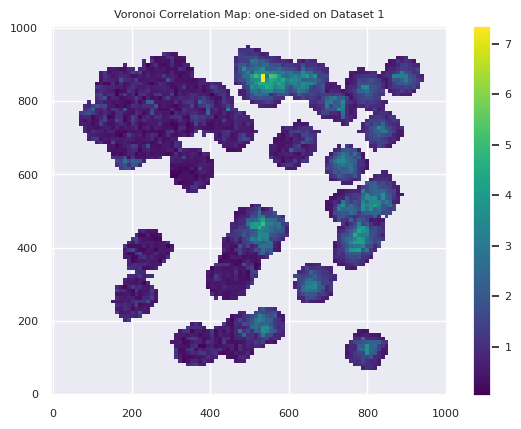

In [14]:
diffs_pixels = compute_avg_dissimilarity_classes_pixels(points1, pixels1, r=50, c1mask=c1mask, c2mask=None, N_circle= N_circle)
plot_measure(Xs, Ys, diffs_pixels, cmap_norm = 'regular')
plt.title("Voronoi Correlation Map: one-sided on Dataset 1")
plt.savefig("figures/voronoi_correlation_map_one_sided_d1.png")

## two sided

differences in average distance over the circle
high absolute values on either side represent exclusion
values close to 0 represent colocalisation

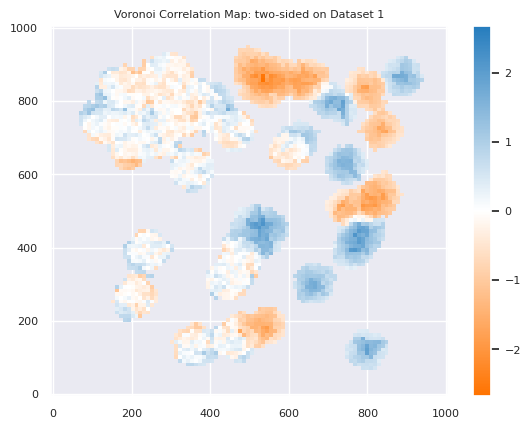

In [15]:
diffs_pixels_dif = compute_avg_dissimilarity_classes_pixels(points1, pixels1, r=50, c1mask=c1mask, c2mask=None, N_circle= N_circle, dissimilarity = "difference")
plot_measure(Xs, Ys, diffs_pixels_dif, cmap_norm = 'linear')
plt.title("Voronoi Correlation Map: two-sided on Dataset 1")
plt.savefig("figures/voronoi_correlation_map_two_sided_d1.png")

In [16]:
#old comparison. a bit darker maybe but same patterns

# avg_d_pixels = compute_avg_dist_pixels_class(points, pixels, r=50, c1mask=c1mask, c2mask=None, N_circle= N_circle)
# diffs = avg_d_pixels[:, 0] - avg_d_pixels[:, 1]
# plot_measure(Xs, Ys, diffs, cmap_norm = 'linear')

In [27]:
# N_circle = 100 # number of points around each circle to sample
# N_pixels_x = 100
# N_pixels_y = N_pixels_x
# Xs = np.linspace(xMin, xMax, N_pixels_x)
# Ys = np.linspace(yMin, yMax, N_pixels_y)
# pixels = np.asarray([ p for p in itertools.product(Xs, Ys )])


# for r in [50]:
    
#     avg_d_pixels = compute_avg_dist_pixels_class(pixels, r=r, c1mask=c1mask, c2mask=None, N_circle= N_circle)

#     diffs = avg_d_pixels[:, 0] - avg_d_pixels[:, 1]
# #     diffs_normalized = diffs/np.max(np.abs(diffs))

#     plot_measure2(Xs, Ys, diffs)


# Variance for heterogeneity/structure

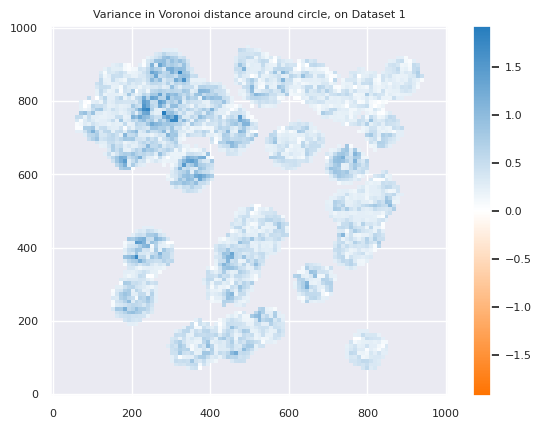

In [19]:
for r in [50] : #, 100, 200]:
    vars_pixels = compute_var_pixels(points1, pixels1, r=r, N_circle= N_circle)

    plot_measure(Xs, Ys, vars_pixels, cmap_norm = 'linear')
    plt.title("Variance in Voronoi distance around circle, on Dataset 1")
    plt.savefig("figures/variance_voronoi_d1.png")

# compare to ratio of points of one class to points of the other class



In [21]:
def compute_relative_diff_in_nb(points, pixels, r, c1mask, c2mask=None):
    
    rel_dif_pixels = np.zeros((pixels.shape[0], 1))

    for i, p in enumerate(pixels):

        p = np.expand_dims(np.asarray(p), axis=0)

        # find points in circle of each class
        points_circle_c1, points_circle_c2 = find_data_points_in_disk(points, p, r, c1mask, c2mask)

        # if number of points for both classes is too low, we can't compute voronoi cells so we don't know if they are colocalized. we set them to NA
        if len(points_circle_c1) == 0 and len(points_circle_c2) == 0 :
             rel_dif = np.nan    
        
        else:
            rel_dif = (len(points_circle_c1) - len(points_circle_c2))/ (len(points_circle_c1) +len(points_circle_c2))
       
        rel_dif_pixels[i] = rel_dif
        
    return rel_dif_pixels

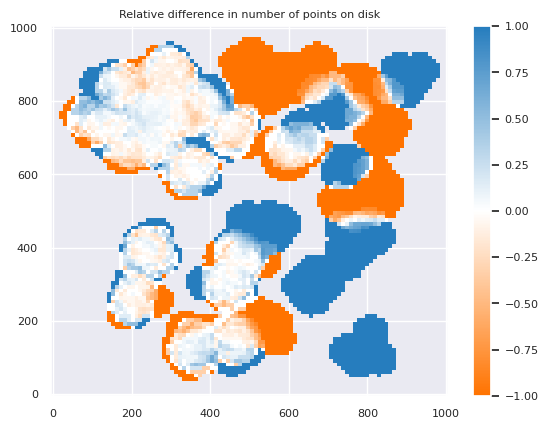

In [23]:
rel_dif_pixels = compute_relative_diff_in_nb(points1, pixels1, r=50, c1mask=c1mask)
plot_measure(Xs, Ys, rel_dif_pixels, cmap_norm = "linear")
plt.title("Relative difference in number of points on disk")
plt.savefig("figures/rel_dif_d1.png")

## Adding normalization by ideal gas

on average, on a circle, what is the difference/distance between Voronoi distances between classes?



I could do, generate poisson process for 2 classes across the board

in a square of side 2r, generate poisson process with dataset density for each class. 
count average on circle of dist of voronoi distances


actually, addding a normalization will only change the scaling because it doesn't depend on the pixel. but i could maybe add it inside the distance between distance function just to see.

In [68]:
N_total = points.shape[0]
N_c1 = np.count_nonzero(c1mask)
N_c2 = np.count_nonzero(np.logical_not(c1mask))

areaTotal, xDelta, yDelta = calculate_area_rectangle(xMin, xMax, yMin, yMax)
density = points.shape[0]/areaTotal
N_poisson = 1000
r=50

xMin = -r
xMax = r
yMin= -r
yMax = r

avgs = np.zeros(N_poisson)

for n in range(N_poisson):
    xx, yy = Poisson_point_process(N_c1/areaTotal, xMin, xMax, yMin, yMax, show = False)
    poisson_points_c1 = np.concatenate((xx,yy),axis=1)

    xx, yy = Poisson_point_process(N_c2/areaTotal, xMin, xMax, yMin, yMax, show = False)
    poisson_points_c2 = np.concatenate((xx,yy),axis=1)

    cur_poisson_points = np.concatenate((poisson_points_c1, poisson_points_c2))
    c1mask_poisson = np.concatenate((np.ones(len(poisson_points_c1)), np.zeros(len(poisson_points_c2)))).astype(bool)
#   c2mask = 

#     print(len(cur_poisson_points))



    # for each class
    center = np.asarray([0,0])
#     print(center)

    avg = avg_on_circle_distance_of_distances(cur_poisson_points, center, r, c1mask_poisson, c2mask=None, N_circle = 100, dissimilarity = 'squared_distance')
#     print(avg)
    avgs[n] = avg

    


KeyboardInterrupt: 

In [54]:
print(np.mean(avgs))
print(np.std(avgs))

3.95988
1.7778408212210677


In [27]:
# for one class, computing avg distances on circle. 
# could be used to normalize the double sided one maybe? actually the one sided, with intuition that poisson distances are the maximum dissimilarity we can expect. hmm actually no because it has the density of both classes combined. well i guess it's still an upper bound.

N_total = points1.shape[0]
N_c1 = np.count_nonzero(c1mask)
N_c2 = np.count_nonzero(np.logical_not(c1mask))

areaTotal, xDelta, yDelta = calculate_area_rectangle(xMin, xMax, yMin, yMax)
density = points1.shape[0]/areaTotal
N_poisson = 100
r=50

xMin = -r
xMax = r
yMin= -r
yMax = r

ds = np.zeros(N_poisson)

for n in range(N_poisson):
    xx, yy = Poisson_point_process(N_total/areaTotal, xMin, xMax, yMin, yMax, show = False)
    poisson_points = np.concatenate((xx,yy),axis=1)

    
    center = np.expand_dims(np.asarray([0,0]), axis=0)
    
#     print(center.shape)
    p_is = sample_on_circle(center, r, N_circle) # so that the points are the same for both classes

    ds_circle = get_distances_on_circle(center, poisson_points, p_is)
#     print(center)


    ds[n] = np.mean(ds_circle)


    
print(np.mean(ds))
print(np.std(ds))

QhullError: QH6214 qhull input error: not enough points(3) to construct initial simplex (need 4)

While executing:  | qhull v Qx Qc Qbb
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1491869254  voronoi  Qxact-merge  Qcoplanar-keep  Qbbound-last
  _zero-centrum  Qinterior-keep  _maxoutside  0


In [24]:
poisson_mean_ds = np.mean(ds)

diffs_pixels = compute_avg_dissimilarity_classes_pixels(points, pixels, r=50, c1mask=c1mask, c2mask=None, N_circle= N_circle, dissimilarity = "squared_distance_normalized", normalization_factor = poisson_mean_ds)
plot_measure(Xs, Ys, diffs_pixels, cmap_norm = 'regular')

plt.title("Voronoi Correlation Map: one-sided and Normalized on Dataset 1")
plt.savefig("voronoi_correlation_map_one_sided_normalized_d1.png")
# doesn't change much


NameError: name 'ds' is not defined

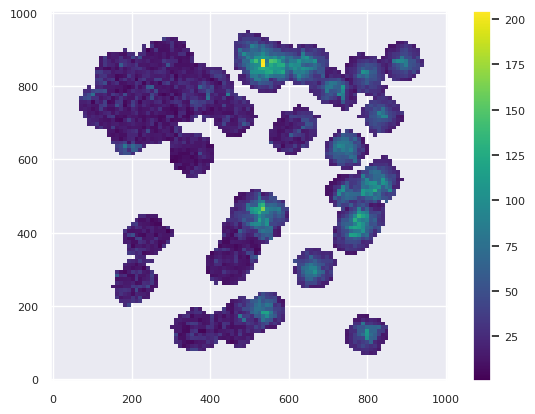

In [80]:
poisson_mean_ds = np.mean(avgs)

diffs_pixels = compute_avg_dissimilarity_classes_pixels(points, pixels, r=50, c1mask=c1mask, c2mask=None, N_circle= N_circle, dissimilarity = "squared_distance")
diffs_pixels = diffs_pixels/poisson_mean_ds
plot_measure(Xs, Ys, diffs_pixels, cmap_norm = 'regular')


# doesn't change much


# Second Dataset

In [28]:
df = pd.read_csv('./ROI-0_MainText.csv')
labels = {'T Helper Cell' : 1,
                   'Regulatory T Cell' : 2,
                   'Cytotoxic T Cell' : 3,
                   'Macrophage' : 4,
                   'Neutrophil' : 5,
                   'Epithelium' : 6
                    }
df

,Unnamed: 0,x,y,Celltype,Celltype_asNumeric,Epithelium,Epithelium_asNumeric,CD4,CD4_asNumeric
0,0,15.00,2.00,T Helper Cell,5,Negative,0,4.461036,4.461036
1,1,36.75,6.75,T Helper Cell,5,Negative,0,9.262379,9.262379
2,2,11.75,8.25,T Helper Cell,5,Negative,0,6.959003,6.959003
3,3,65.75,9.00,T Helper Cell,5,Negative,0,16.364574,16.364574
4,4,22.25,10.75,T Helper Cell,5,Negative,0,4.528144,4.528144
...,...,...,...,...,...,...,...,...,...
6780,6780,633.75,998.00,Epithelium,1,Positive,1,1.151142,1.151142
6781,6781,525.25,997.25,Epithelium,1,Positive,1,0.612260,0.612260
6782,6782,543.25,998.75,Epithelium,1,Positive,1,0.883633,0.883633
6783,6783,503.50,999.00,Epithelium,1,Positive,1,0.438527,0.438527


In [29]:
print(df['Celltype'].unique())

df = df.loc[df['Celltype'].isin(['T Helper Cell', 'Epithelium'])] #'Macrophage'])]

print(df)
points2 = np.asarray([df['x'],df['y']]).transpose()


['T Helper Cell' 'Regulatory T Cell' 'Cytotoxic T Cell' 'Macrophage'
 'Neutrophil' 'Epithelium']
      Unnamed: 0       x       y       Celltype  Celltype_asNumeric  \
0              0   15.00    2.00  T Helper Cell                   5   
1              1   36.75    6.75  T Helper Cell                   5   
2              2   11.75    8.25  T Helper Cell                   5   
3              3   65.75    9.00  T Helper Cell                   5   
4              4   22.25   10.75  T Helper Cell                   5   
...          ...     ...     ...            ...                 ...   
6780        6780  633.75  998.00     Epithelium                   1   
6781        6781  525.25  997.25     Epithelium                   1   
6782        6782  543.25  998.75     Epithelium                   1   
6783        6783  503.50  999.00     Epithelium                   1   
6784        6784  685.50  999.25     Epithelium                   1   

     Epithelium  Epithelium_asNumeric        CD4  

In [30]:
xMin = 0
xMax = 1000
yMin = xMin
yMax = xMax

In [31]:
my_colors= {5:(0, 0.4, 0.7), 1: (1.0, 0.45, 0.0)}

df['Celltype_asNumeric'].values

array([5, 5, 5, ..., 1, 1, 1])

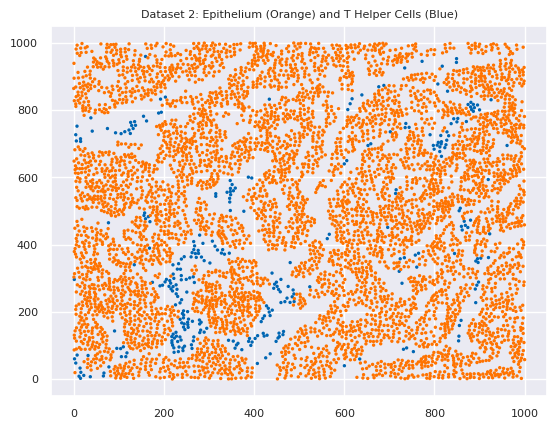

In [32]:

plt.scatter(points2[:,0], points2[:,1], c = [my_colors[i] for i in df['Celltype_asNumeric'].values], s=2)

c1mask = df['Celltype'] == 'T Helper Cell'
c2mask = df['Celltype'] == 'Epithelium'

plt.title("Dataset 2: Epithelium (Orange) and T Helper Cells (Blue)")
plt.savefig("d2.png")

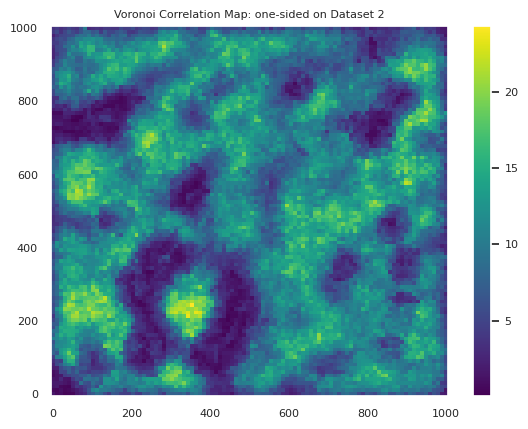

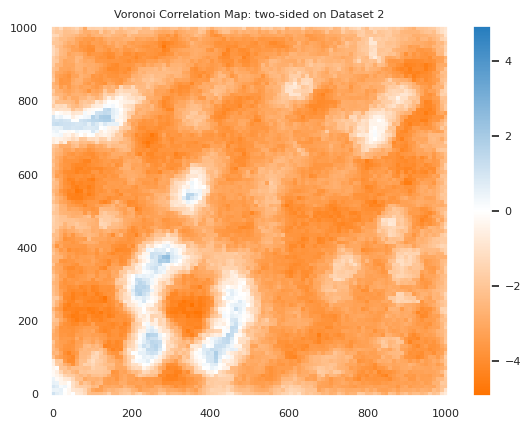

In [33]:
N_circle = 100 # number of points around each circle to sample
N_pixels_x = 100
N_pixels_y = N_pixels_x
Xs = np.linspace(xMin, xMax, N_pixels_x)
Ys = np.linspace(yMin, yMax, N_pixels_y)
pixels2 = np.asarray([ p for p in itertools.product(Xs, Ys )])


for r in [50]:
    
#     avg_d_pixels = compute_avg_dist_pixels_class(points2, pixels, r=r, c1mask=c1mask, c2mask=None, N_circle= N_circle)

#     diffs = avg_d_pixels[:, 0] - avg_d_pixels[:, 1]
# #     diffs_normalized = diffs/np.max(np.abs(diffs))



#     print(c1mask)
    diffs_pixels = compute_avg_dissimilarity_classes_pixels(points2, pixels2, r=r, c1mask=c1mask, c2mask=None, N_circle= N_circle, dissimilarity = "squared_distance")
    plot_measure(Xs, Ys, diffs_pixels, cmap_norm = 'regular')
    plt.title("Voronoi Correlation Map: one-sided on Dataset 2")
    plt.savefig("voronoi_correlation_map_one_sided_d2.png")
    
    
    diffs_pixels = compute_avg_dissimilarity_classes_pixels(points2, pixels2, r=r, c1mask=c1mask, c2mask=None, N_circle= N_circle, dissimilarity = "difference")
    plot_measure(Xs, Ys, diffs_pixels, cmap_norm = 'linear')
    plt.title("Voronoi Correlation Map: two-sided on Dataset 2")
    plt.savefig("voronoi_correlation_map_two_sided_d2.png")



#     plot_measure2(Xs, Ys, diffs)


try bigger r

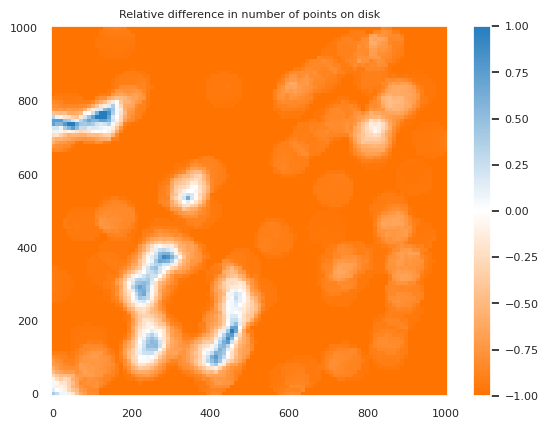

In [34]:
rel_dif_pixels = compute_relative_diff_in_nb(points2, pixels2, r, c1mask)
plot_measure(Xs, Ys, rel_dif_pixels, cmap_norm = "linear")
plt.title("Relative difference in number of points on disk")
plt.savefig("figures/rel_dif_d2.png")

so it's basically the same as relative differences in number

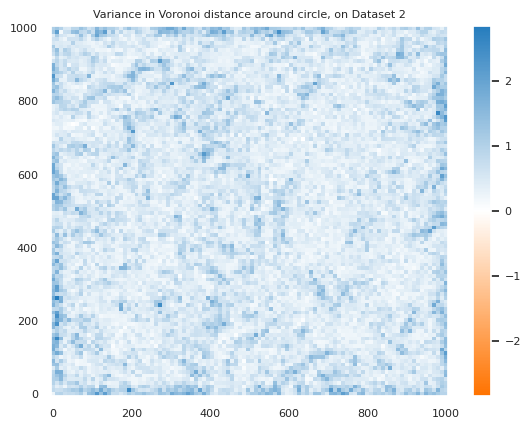

In [35]:
# Variance in distances across circle to measure structure in a disk
for r in [50] : #, 100, 200]:
    vars_pixels = compute_var_pixels(points2, pixels2, r=r, N_circle= N_circle)

    plot_measure(Xs, Ys, vars_pixels, cmap_norm = 'linear')
    plt.title("Variance in Voronoi distance around circle, on Dataset 2")
    plt.savefig("figures/variance_voronoi_d2.png")